<a href="https://colab.research.google.com/github/wanburana/AT82.01-brain-project-group-4/blob/main/Jirasak/code/cnnrnn_train_subject_dependent_random_split.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Implementing the paper [Emotion Recognition from Multi-Channel EEG through Parallel Convolutional Recurrent Neural Network](https://ieeexplore.ieee.org/document/8489331) with with some modification to dropout, learning rate, L2 regularization to prevent overfitting

In [1]:
!gdown --id 1OLUTwrQIhitY16HrEDJBPz2Sd7tSYqRi # cnn_preprocessed
!gdown --id 1-78ZfPixbqA1jLVGFXtrNCJ9pq4Cgpz9 # rnn_preprocessed

!gdown --id 1sacOlggvbtn5ATVkrb3DJqfpSg7eI3Fo # label

Downloading...
From: https://drive.google.com/uc?id=1OLUTwrQIhitY16HrEDJBPz2Sd7tSYqRi
To: /content/eeg_preprocessed_cnn_memmap.dat
100% 3.19G/3.19G [00:18<00:00, 168MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1-78ZfPixbqA1jLVGFXtrNCJ9pq4Cgpz9
To: /content/eeg_preprocessed_rnn_memmap.dat
100% 1.26G/1.26G [00:12<00:00, 98.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1sacOlggvbtn5ATVkrb3DJqfpSg7eI3Fo
To: /content/deap_label_raw.csv
100% 24.8k/24.8k [00:00<00:00, 39.3MB/s]


In [2]:
import os
from glob import glob
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch import optim

In [3]:
label_df = pd.read_csv('deap_label_raw.csv')
label_df_binarized = (label_df >= 5).astype('int')
label_df_binarized



,valence,arousal,dominance,liking
0,1,1,1,1
1,1,1,1,1
2,1,1,1,1
3,0,1,1,1
4,1,0,1,1
...,...,...,...,...
1275,0,1,1,0
1276,0,1,1,0
1277,0,1,1,0
1278,0,1,0,0


In [4]:
cnn_memmap_path = 'eeg_preprocessed_cnn_memmap.dat'
cnn_data = np.memmap(cnn_memmap_path, dtype='float32', mode='r', shape=(1280, 60, 9, 9, 128))

rnn_memmap_path = 'eeg_preprocessed_rnn_memmap.dat'
rnn_data = np.memmap(rnn_memmap_path, dtype='float32', mode='r', shape=(1280, 60, 32, 128))

cnn_data_reshaped = cnn_data.reshape(-1, 9, 9, 128)
rnn_data_reshaped = rnn_data.reshape(-1, 32, 128)

In [31]:
# randomly split the data with 20 % test data 


clip_per_participants = 40
segment_per_sample = 60

data_point_per_participant = clip_per_participants * segment_per_sample


In [25]:
test_samples=0.2

array([1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [36]:
# expand 

valence_label = label_df_binarized['valence'].values
arousal_label = label_df_binarized['arousal'].values

# repeat the label by 60 to match the new data
valence_label_tiled = np.tile(valence_label.reshape(-1, 1), reps=[60]).reshape(-1)
arousal_label_tiled = np.tile(arousal_label.reshape(-1, 1), reps=[60]).reshape(-1)

In [38]:
valence_label_tiled[:data_point_per_participant]

0.475

In [41]:
# from 1st participant
# randomly select 80% as train, and 20% as test
# stratify splitting on label of 1st participant for more balance data
expand_indices = np.arange(data_point_per_participant)
train_indices, test_indices = train_test_split(expand_indices,  test_size=test_samples, shuffle=True, stratify=valence_label_tiled[:data_point_per_participant])

In [40]:
print(len(train_indices), len(test_indices)) 

1920 480


In [42]:
train_cnn_data = cnn_data_reshaped[train_indices]
test_cnn_data = cnn_data_reshaped[test_indices]

train_rnn_data = rnn_data_reshaped[train_indices]
test_rnn_data = rnn_data_reshaped[test_indices]

train_valence_label = valence_label_tiled[train_indices]
test_valence_label = valence_label_tiled[test_indices]

In [43]:
class CNNRNNDatasetV2(Dataset):
    def __init__(self, cnn_data, rnn_data, label):
        self.cnn_data = cnn_data
        self.rnn_data = rnn_data
        self.label = label

    def __len__(self):
        return len(self.cnn_data)

    def __getitem__(self, idx):
        cnn_feature = np.array(self.cnn_data[idx])
        rnn_feature = np.array(self.rnn_data[idx])

        target = np.array(self.label[idx])

        return (torch.from_numpy(cnn_feature), torch.from_numpy(rnn_feature)), torch.from_numpy(target)    

In [44]:
BATCH_SIZE = 128

In [45]:
train_ds = CNNRNNDatasetV2(train_cnn_data, train_rnn_data, train_valence_label)
test_ds = CNNRNNDatasetV2(test_cnn_data, test_rnn_data, test_valence_label)

train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [46]:
class RNNCNN(nn.Module):
    def __init__(self, ):
        super().__init__()
        self.cnn_part = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(4,4), padding='same'),
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(4,4), padding='same'),
            nn.BatchNorm2d(64),
            nn.ELU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(4,4), padding='same'),
            nn.BatchNorm2d(128),
            nn.ELU(),
        )
        self.one_one_conv = nn.Conv2d(in_channels=16384, out_channels=13, kernel_size=(1,1))

        self.lstm_part = nn.LSTM(input_size=128, hidden_size=32, num_layers=2, dropout=0.6, batch_first=True)

        self.final_part = nn.Sequential(nn.Linear(1085, 512),
                                        nn.Dropout(0.6),
                                        nn.Linear(512, 2)
                                        )
    def forward(self, cnn_data, rnn_data):

        # CNN
        cnn_data = cnn_data.view(-1, 1, 9, 9, 128)
        to_be_concatenated = []
        for channel in range(cnn_data.shape[-1]):
            result = self.cnn_part(cnn_data[...,channel])
            to_be_concatenated.append(result)
        
        result_concatenated = torch.concat(to_be_concatenated, axis=1)
        result_concatenated_one_one_conv = self.one_one_conv(result_concatenated)
        spatial_feature_vector = result_concatenated_one_one_conv.view(-1, 9*9*13)

        # RNN
        out, (h_n,c_n) = self.lstm_part(rnn_data)
        temporal_feature_vector = h_n[-1]

        # Combine CNN and RNN
        spatial_temporal_concat = torch.concat([spatial_feature_vector, temporal_feature_vector],1)

        output = self.final_part(spatial_temporal_concat)
        return output

In [47]:

lr = 3e-4
weight_decay = 0.5




In [48]:
# *cnn_rnn_data, label = next(iter(train_dataloader))

In [49]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [50]:
from tqdm.auto import tqdm

In [51]:
EPOCHS = 50

model = RNNCNN()
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

train_accuracy_history = []
test_accuracy_history = []

train_loss_history = []
test_loss_history = []

for epoch in tqdm(range(EPOCHS)):
    model.train()

    train_correct = []
    test_correct = []

    train_loss_epoch = 0
    test_loss_epoch = 0

    for ii, ((cnn_rnn_data), label) in enumerate(tqdm(train_dataloader)):
        

        cnn_data, rnn_data = cnn_rnn_data
        cnn_data, rnn_data, label = cnn_data.to(device), rnn_data.to(device), label.to(device)
        
        pred = model(cnn_data, rnn_data)
        loss = criterion(pred, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_correct.extend((torch.argmax(pred, 1) == label).int().detach().cpu().numpy())
        train_loss_epoch += loss.item()

    train_accuracy = np.mean(train_correct)
    train_accuracy_history.append(train_accuracy)
    
    current_epoch_train_loss = np.mean(train_loss_epoch)
    train_loss_history.append(current_epoch_train_loss)
    
    print(f'Train accuracy:{train_accuracy}, Train Loss:{current_epoch_train_loss}')

    with torch.no_grad():
        model.eval()
        for jj, ((cnn_rnn_data_test), label_test) in enumerate((test_dataloader)):
            cnn_data_test, rnn_data_test = cnn_rnn_data_test
            cnn_data_test, rnn_data_test, label_test = cnn_data_test.to(device), rnn_data_test.to(device), label_test.to(device)

            pred_test = model(cnn_data_test, rnn_data_test)
            loss_test = criterion(pred_test, label_test)

            test_correct.extend((torch.argmax(pred_test, 1) == label_test).int().detach().cpu().numpy())
            test_loss_epoch += loss_test.item()


    test_accuracy = np.mean(test_correct)
    test_accuracy_history.append(test_accuracy)

    current_epoch_test_loss = np.mean(test_loss_epoch)
    test_loss_history.append(current_epoch_test_loss)

    print(f'Test accuracy:{test_accuracy}, Test Loss:{current_epoch_test_loss}')


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:443: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:647.)
  self.padding, self.dilation, self.groups)


Train accuracy:0.8453125, Train Loss:5.558513581752777
Test accuracy:0.9583333333333334, Test Loss:0.8677825480699539


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9645833333333333, Train Loss:2.3324143067002296
Test accuracy:0.9833333333333333, Test Loss:0.579426184296608


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9869791666666666, Train Loss:1.7295969426631927
Test accuracy:0.9833333333333333, Test Loss:0.5196064785122871


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9916666666666667, Train Loss:1.5284742936491966
Test accuracy:0.98125, Test Loss:0.48894520103931427


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9901041666666667, Train Loss:1.3799160420894623
Test accuracy:0.9770833333333333, Test Loss:0.4818436726927757


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9895833333333334, Train Loss:1.2566509768366814
Test accuracy:0.9708333333333333, Test Loss:0.4336363673210144


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.99375, Train Loss:1.111611533910036
Test accuracy:0.9791666666666666, Test Loss:0.39995531737804413


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9942708333333333, Train Loss:1.06538250669837
Test accuracy:0.9729166666666667, Test Loss:0.4394891709089279


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9916666666666667, Train Loss:1.0309691987931728
Test accuracy:0.9833333333333333, Test Loss:0.38463832437992096


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.99375, Train Loss:0.9581407867372036
Test accuracy:0.9895833333333334, Test Loss:0.3859541639685631


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9947916666666666, Train Loss:0.9364592209458351
Test accuracy:0.9791666666666666, Test Loss:0.33318912982940674


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9953125, Train Loss:0.8727269135415554
Test accuracy:0.9833333333333333, Test Loss:0.37128209322690964


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9895833333333334, Train Loss:1.0010659359395504
Test accuracy:0.9791666666666666, Test Loss:0.3342706933617592


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9921875, Train Loss:1.0541978478431702
Test accuracy:0.98125, Test Loss:0.35824329406023026


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9911458333333333, Train Loss:0.9725151211023331
Test accuracy:0.9875, Test Loss:0.35044892877340317


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9921875, Train Loss:0.9506206326186657
Test accuracy:0.98125, Test Loss:0.29848168045282364


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9833333333333333, Train Loss:1.1773374862968922
Test accuracy:0.9708333333333333, Test Loss:0.41915810108184814


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9916666666666667, Train Loss:0.9490788094699383
Test accuracy:0.9833333333333333, Test Loss:0.3430091589689255


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9916666666666667, Train Loss:0.9243337400257587
Test accuracy:0.9875, Test Loss:0.32738207280635834


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.99375, Train Loss:0.8618444614112377
Test accuracy:0.9916666666666667, Test Loss:0.3085034564137459


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9927083333333333, Train Loss:0.8812311291694641
Test accuracy:0.98125, Test Loss:0.33001863211393356


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9942708333333333, Train Loss:0.9528568387031555
Test accuracy:0.975, Test Loss:0.3656843900680542


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9921875, Train Loss:0.9005507007241249
Test accuracy:0.9895833333333334, Test Loss:0.3020060583949089


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9932291666666667, Train Loss:0.8369304277002811
Test accuracy:0.9666666666666667, Test Loss:0.40811532735824585


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9911458333333333, Train Loss:1.0086358450353146
Test accuracy:0.96875, Test Loss:0.33406244218349457


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9932291666666667, Train Loss:0.884656585752964
Test accuracy:0.98125, Test Loss:0.3068676292896271


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9963541666666667, Train Loss:0.7672402821481228
Test accuracy:0.96875, Test Loss:0.39245814830064774


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9895833333333334, Train Loss:1.013538409024477
Test accuracy:0.98125, Test Loss:0.33353323489427567


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9932291666666667, Train Loss:0.8542359881103039
Test accuracy:0.9770833333333333, Test Loss:0.30429234355688095


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.99375, Train Loss:0.9064641483128071
Test accuracy:0.975, Test Loss:0.3630675673484802


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.990625, Train Loss:1.004664197564125
Test accuracy:0.9770833333333333, Test Loss:0.37577106803655624


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9921875, Train Loss:0.9419309459626675
Test accuracy:0.9854166666666667, Test Loss:0.3036586344242096


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.99375, Train Loss:0.8475889712572098
Test accuracy:0.98125, Test Loss:0.3530390337109566


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9963541666666667, Train Loss:0.8231660053133965
Test accuracy:0.9854166666666667, Test Loss:0.29190992936491966


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9921875, Train Loss:0.8649289757013321
Test accuracy:0.9833333333333333, Test Loss:0.316989716142416


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9921875, Train Loss:0.8814234100282192
Test accuracy:0.9854166666666667, Test Loss:0.29638462886214256


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9942708333333333, Train Loss:0.7519632764160633
Test accuracy:0.98125, Test Loss:0.31722937151789665


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9921875, Train Loss:0.8500654473900795
Test accuracy:0.9729166666666667, Test Loss:0.34995753318071365


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9947916666666666, Train Loss:0.8257214948534966
Test accuracy:0.9875, Test Loss:0.28898294270038605


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9947916666666666, Train Loss:0.733084112405777
Test accuracy:0.96875, Test Loss:0.40006357431411743


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9895833333333334, Train Loss:1.0521498955786228
Test accuracy:0.96875, Test Loss:0.3612337075173855


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.99375, Train Loss:0.8110126554965973
Test accuracy:0.9666666666666667, Test Loss:0.35464874655008316


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9942708333333333, Train Loss:0.7597794979810715
Test accuracy:0.9791666666666666, Test Loss:0.30342016369104385


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9932291666666667, Train Loss:0.7573083490133286
Test accuracy:0.98125, Test Loss:0.2639554515480995


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9973958333333334, Train Loss:0.7316088974475861
Test accuracy:0.9729166666666667, Test Loss:0.2962947487831116


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9947916666666666, Train Loss:0.7330933455377817
Test accuracy:0.9854166666666667, Test Loss:0.3098053075373173


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9947916666666666, Train Loss:0.7934302873909473
Test accuracy:0.9770833333333333, Test Loss:0.3117564097046852


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9947916666666666, Train Loss:0.7562025040388107
Test accuracy:0.9791666666666666, Test Loss:0.34854549169540405


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9984375, Train Loss:0.6449692510068417
Test accuracy:0.9875, Test Loss:0.2565239332616329


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9911458333333333, Train Loss:0.8549998179078102
Test accuracy:0.9791666666666666, Test Loss:0.33307021856307983


Text(0.5, 1.0, 'epochs vs accuracy')

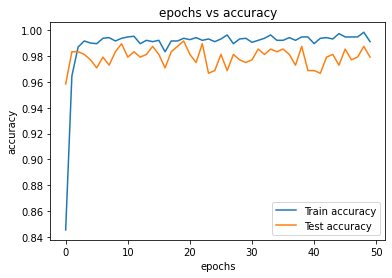

In [52]:
plt.plot(train_accuracy_history, label='Train accuracy')
plt.plot(test_accuracy_history, label='Test accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title("epochs vs accuracy")

Text(0.5, 1.0, 'epochs vs loss')

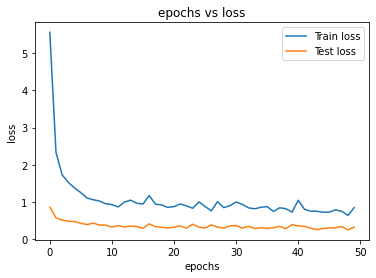

In [53]:
plt.plot(train_loss_history, label='Train loss')
plt.plot(test_loss_history, label='Test loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title("epochs vs loss")